In [3]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


flu_trends = pd.read_csv("C:/Users/diogo/Downloads/flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

Week
2009-06-29/2009-07-05    180
2009-07-06/2009-07-12    115
2009-07-13/2009-07-19    132
2009-07-20/2009-07-26    109
2009-07-27/2009-08-02    120
                        ... 
2016-05-30/2016-06-05     90
2016-06-06/2016-06-12     55
2016-06-13/2016-06-19     33
2016-06-20/2016-06-26     27
2016-06-27/2016-07-03     22
Freq: W-SUN, Name: FluVisits, Length: 366, dtype: int64

First we'll prepare our target series (weekly office visits for the flu) for multistep forecasting. Once this is done, training and prediction will be very straightfoward.

In [14]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0
...,...,...,...,...
2016-04-11/2016-04-17,712.0,955.0,1100.0,1326.0
2016-04-18/2016-04-24,616.0,712.0,955.0,1100.0
2016-04-25/2016-05-01,578.0,616.0,712.0,955.0


### Multioutput model

We'll use linear regression as a MultiOutput strategy. Once we have our data prepared for multiple outputs, training and prediction is the same as always.

In [6]:

# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Remember that a multistep model will produce a complete forecast for each instance used as input. There are 269 weeks in the training set and 90 weeks in the test set, and we now have an 8-step forecast for each of these weeks.

Train RMSE: 389.12
Test RMSE: 582.33


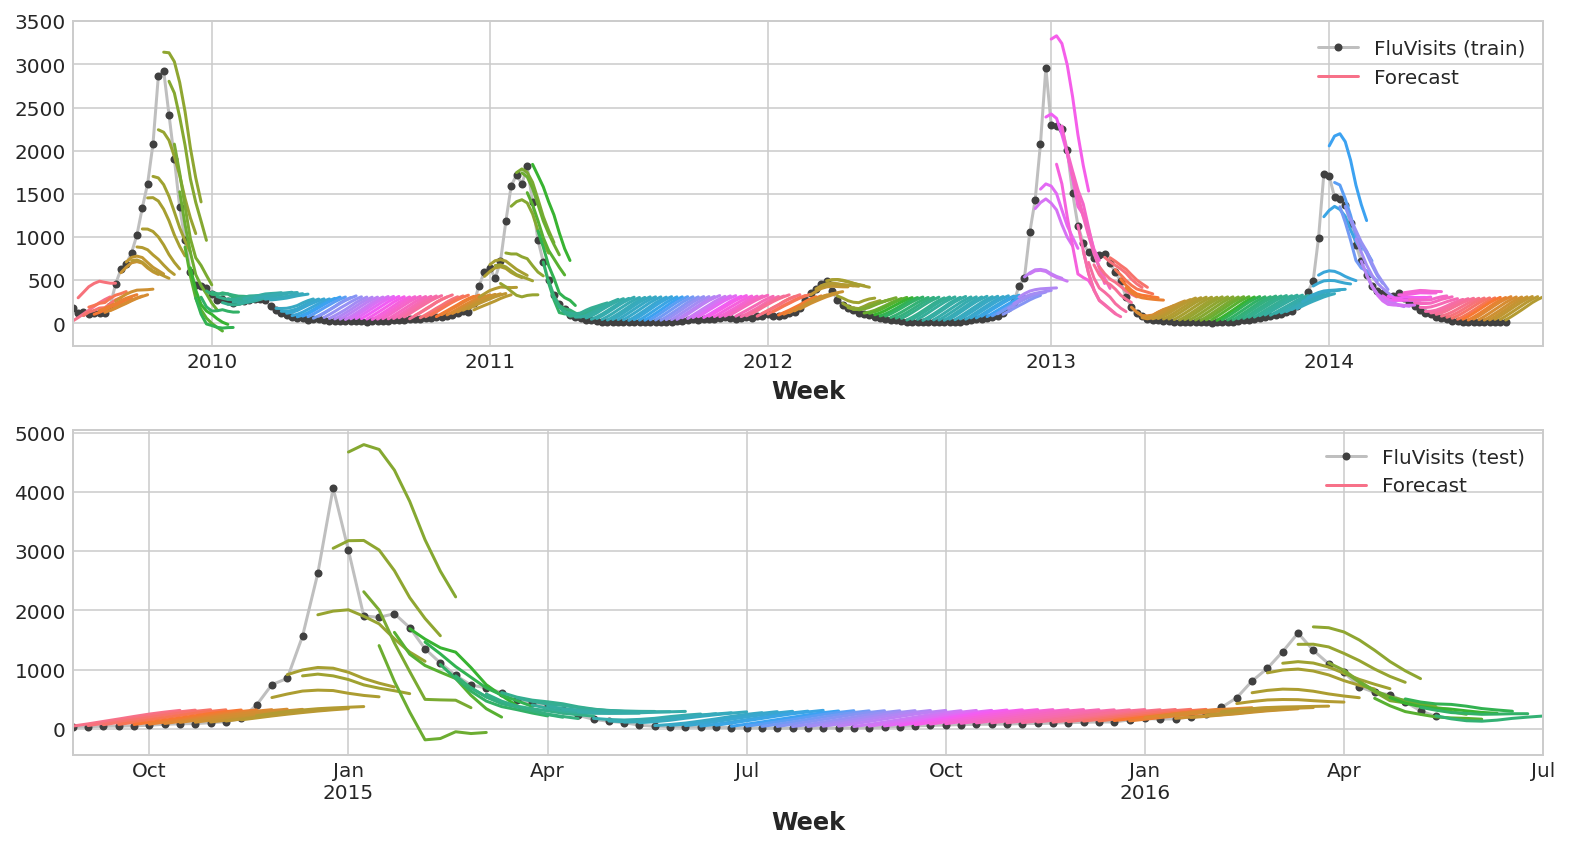

In [5]:

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}")

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

### Direct strategy

XGBoost can't produce multiple outputs for regression tasks. But by applying the Direct reduction strategy, we can still use it to produce multistep forecasts. This is as easy as wrapping it with scikit-learn's `MultiOutputRegressor`.

In [7]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

XGBoost here is clearly overfitting on the training set. But on the test set it seems it was able to capture some dynamics of the flu season better than the linear regression model. It would likely do even better with some hyperparameter tuning.

Train RMSE: 1.22
Test RMSE: 526.45


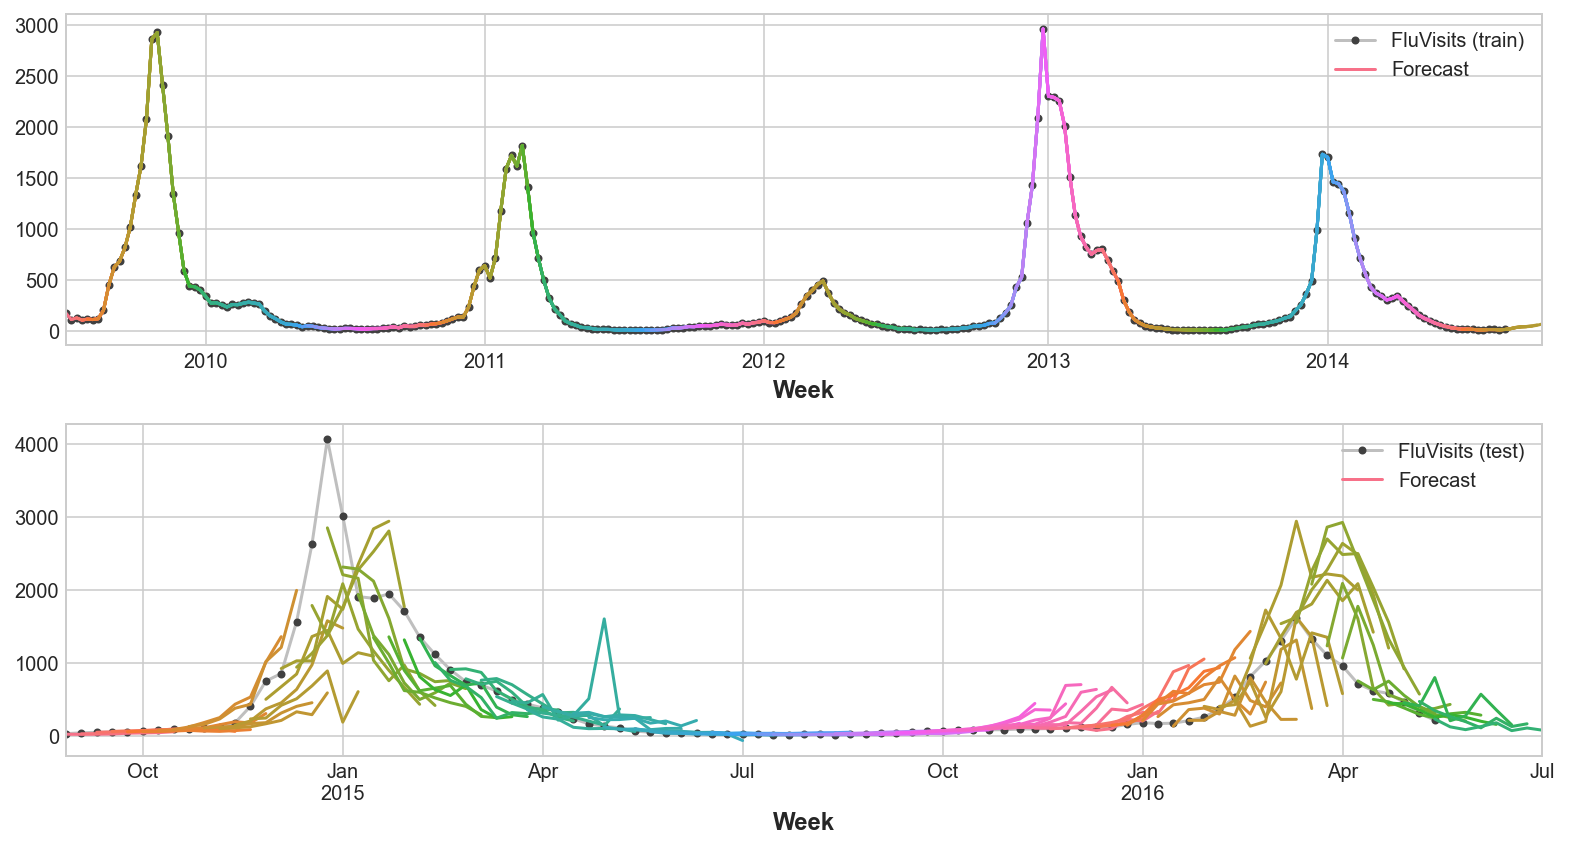

In [8]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}")

palette = dict(palette='husl', n_colors=64)
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

To use the DirRec strategy, you would only need to replace `MultiOutputRegressor` with another scikit-learn wrapper, `RegressorChain`. The Recursive strategy we would need to code ourselves.

# Your Turn #

[**Create a forecasting dataset**](https://www.kaggle.com/kernels/fork/20667477) for *Store Sales* and apply the DirRec strategy.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*